# Hypothesis Testing

In [73]:
# Import packages
%matplotlib inline
import matplotlib 
import matplotlib.pyplot as plt
from matplotlib import cm as CM
from matplotlib import mlab as ML
import pandas as pd
import numpy as np
import itertools
from scipy import stats
from scipy.stats import poisson
from scipy.stats import lognorm
from decimal import *

# Read in data
df = pd.read_csv('../output.csv')

## Step 0: Looking at the data again
We have to deal with "bad" bins that have a lot of masked voxels:

C:\Users\Andrew\Anaconda\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


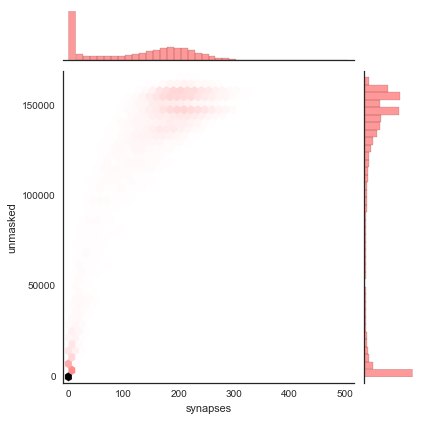

In [2]:
import seaborn as sns

x = df['synapses']
y = df['unmasked']

with sns.axes_style('white'):
    sns.jointplot(x=x, y=y, kind='hex', color='r', 
                  xlim=(x.min()-0.02*np.ptp(x),x.max()+0.02*np.ptp(x)), 
                  ylim=(y.min()-0.02*np.ptp(y),y.max()+0.02*np.ptp(y)),
                  joint_kws={'gridsize':40}, marginal_kws={'bins':40}, stat_func=None);

Weight each bin by the fraction of unmasked voxels (64x64x48 voxels/bin):

There are 6595 blank bins


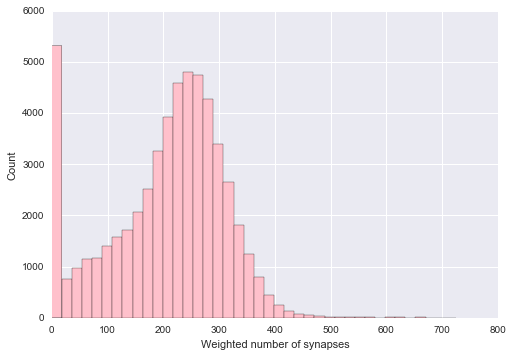

In [3]:
nvox = 64*64*48
df['weighted'] = df['synapses']/df['unmasked']*nvox
syn_wt = df['weighted']

print "There are", df['weighted'].isnull().sum(), "blank bins"

plt.hist(syn_wt, bins = 40, range = (syn_wt.min(), syn_wt.max()),
         color = 'pink');
plt.xlabel('Weighted number of synapses');
plt.ylabel('Count');

Only keep bins with greater than 50% unmasked data:

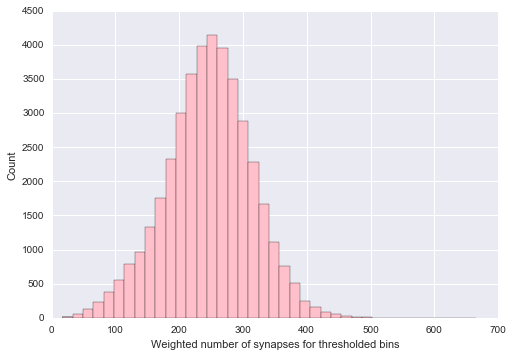

In [4]:
dfthr = df[df['unmasked']>nvox*0.5] # Thresholded data frame
syn_wt_thresh = dfthr['weighted']

plt.hist(syn_wt_thresh, bins = 40, range = (syn_wt_thresh.min(), syn_wt_thresh.max()),
         color = 'pink');
plt.xlabel('Weighted number of synapses for thresholded bins');
plt.ylabel('Count');

Look at different Z-slices:

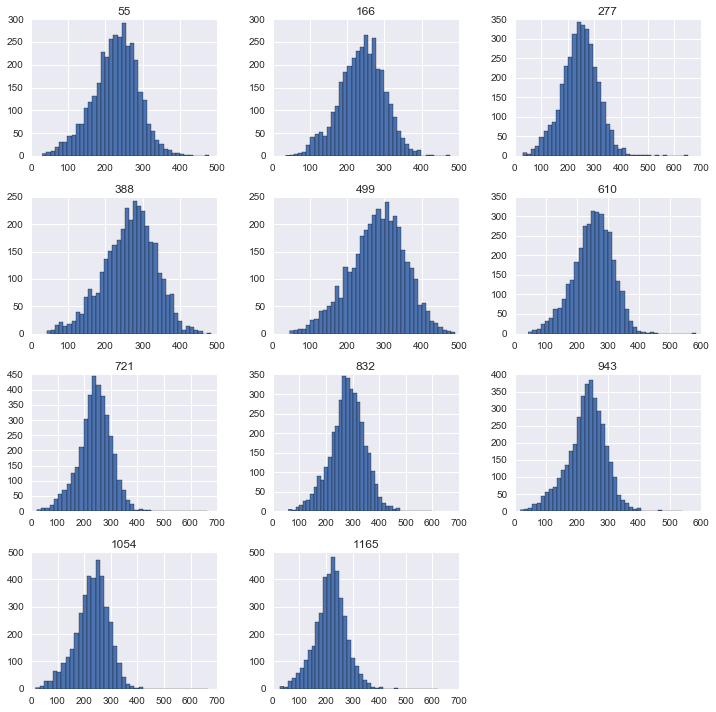

In [5]:
byZ = pd.pivot_table(dfthr, index=['cx','cy'], columns='cz', values='weighted', aggfunc=np.sum);
byZ.hist(bins=40, figsize=(12,12));

## Step 1: Assumptions
* There are 64x64x48 voxels per 3D bin
* $X_i$ is the number of synapses in a 3D bin $i \in \{1, 2, ..., N\}$
* $\lambda$ is average number of synapses per bin
* $N$ is the total number of 3D bins (observations)

## Step 2: Statistical test
$\chi^2 = \sum{\frac{(Observed-Expected)^2}{Expected}}$
* $H_0$: $X_i$ is Poisson (with rate $\lambda$)
* $H_1$: $X_i$ is not Poisson

## Step 3: Test algorithm
* Combine the tails and/or coarsen bins of $X_i$ histogram so that all cells have at least 5 observations (http://www.itl.nist.gov/div898/handbook/eda/section3/eda35f.htm)
* New histogram $O_j$ is the number of observations (3D bins) with $k$ synapses, where $k \in j^{th}$ cell, $j \in \{1,2,...,m\}$ (m total cells)
* Compute $E_j = \sum_{k \in cell(j)}{N\frac{\lambda^k exp(-\lambda)}{k!}}$, $j \in \{1,2,...,m\}$
* $\chi^2 = \sum_{j=1}^{m}{\frac{(O_j-E_j)^2}{E_j}}$
* Degrees of freedom = $m-2$
* Significance level $\alpha = 0.05$
* If $\chi^2 > \chi^2_{1-\alpha,m-2}$, we reject the null hypothesis.
* Otherwise, there is not sufficient evidence to conclude that $X_i$ is not Poisson.
* We can also test Z-slices individually

## Step 4A: Sample data from null model

In [6]:
alpha = 0.05
S = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 100, 200, 300, 400, 500, 1000, 2000]  # sample size
ite = 100
pow_null = []

for j in S:
    
    m = 10  # bin number
    mu = 3 # lambda of Poisson dist
    n = j  # number of sample (sample size)
    
    p_value = []
    boundary = np.linspace(0, 10, (m + 1))
    cumu_prob = poisson.cdf(boundary, mu = mu)
    exp_prob = []
    for i in range(0, m):
        if i == 0:                
            exp_prob = np.append(exp_prob, cumu_prob[i])
        if i > 0:   
            exp_prob = np.append(exp_prob, cumu_prob[i] - cumu_prob[i - 1])
        if i == (m - 1):
            exp_prob = np.append(exp_prob, 1 - sum(exp_prob))    
            
    exp_freq = exp_prob * n
    expected_values = exp_freq
    
    for iteration in range(0, ite):
            
        sample = np.random.poisson(mu, n)
        
        bin_content = []
        for i in range(0, m + 1):
            bin_content = np.append(bin_content, sum(sample <= boundary[i]))
                                    
        obe_freq = []
        for i in range(0, m + 1):
            if i == 0:
                obe_freq = np.append(obe_freq, bin_content[i])
            if i > 0:
                obe_freq = np.append(obe_freq, bin_content[i] - bin_content[i - 1])
         
        observed_values = obe_freq
         
        test_value = stats.chisquare(observed_values,
                                     f_exp= expected_values)[1]
        
        p_value = np.append(p_value, test_value)
    pow_null = np.append(pow_null, (Decimal(sum(p_value < alpha))) / Decimal(len(range(0, ite))))



## Step 4B: Sample data from alternate model

In [7]:
alpha = 0.05
S = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 100, 200, 300, 400, 500, 1000, 2000]  # sample size
ite = 100
pow_alt = []

for j in S:
    
    m = 10  # number of bins
    mu = 3 # lambda of Poisson dist
    n = j  # number of sample (sample size)
    
    p_value = []
    boundary = np.linspace(0, 10, (m + 1))
    cumu_prob = poisson.cdf(boundary, mu = mu)
    exp_prob = []
    
    for i in range(0, m):
        if i == 0:                
            exp_prob = np.append(exp_prob, cumu_prob[i])
        if i > 0:   
            exp_prob = np.append(exp_prob, cumu_prob[i] - cumu_prob[i - 1])
        if i == (m - 1):
            exp_prob = np.append(exp_prob, 1 - sum(exp_prob))    

    exp_freq = exp_prob * n
            
    for iteration in range(0, ite):
    
        sample = np.random.geometric(p = 0.5, size = n)
        
        bin_content = []
        for i in range(0, m + 1):
            bin_content = np.append(bin_content, sum(sample <= boundary[i]))
                                    
        obe_freq = []
        for i in range(0, m + 1):
            if i == 0:
                obe_freq = np.append(obe_freq, bin_content[i])
            if i > 0:
                obe_freq = np.append(obe_freq, bin_content[i] - bin_content[i - 1])
                 
        observed_values = obe_freq
        expected_values = exp_freq
         
        test_value = stats.chisquare(observed_values,
                                     f_exp= expected_values)[1]
        
        p_value = np.append(p_value, test_value)
    pow_alt = np.append(pow_alt, (Decimal(sum(p_value < alpha))) / Decimal(len(range(0, ite))))
    

## Step 5: Plot power vs N on null set

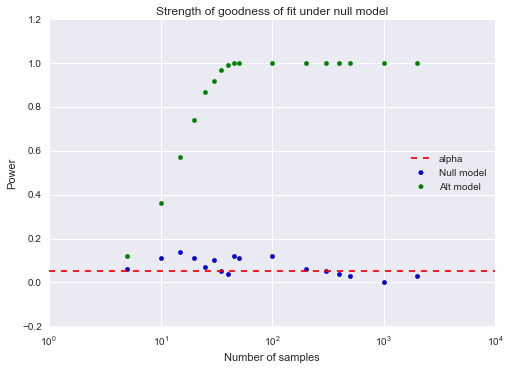

In [8]:
plt.scatter(S, pow_null, hold = True, label = "Null model")
plt.scatter(S, pow_alt, color = "green", hold=True, label = "Alt model")
plt.xscale("log")
plt.xlabel("Number of samples")
plt.ylabel("Power")
plt.title("Strength of goodness of fit under null model")
plt.axhline(alpha, color = "red", linestyle = '--', label = "alpha")
plt.legend(loc = 5)
plt.show()

## Step 6: Apply to data

stepSize of  10  was the lowest possible stepSize to ensure bins for the chi-squared test had at least 5 samples


NameError: name 'observed' is not defined

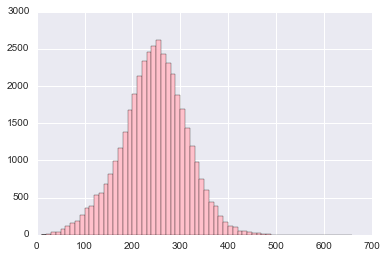

In [78]:
N = np.size(syn_wt_thresh)
stepSize = 10
print "stepSize of ",stepSize," was the lowest possible stepSize to ensure bins for the chi-squared test had at least 5 samples"
boundary = np.arange(np.floor(syn_wt_thresh.min()/stepSize)*stepSize,np.ceil(syn_wt_thresh.max()/stepSize)*stepSize,stepSize);
(observedBin,bin,hi) = plt.hist(syn_wt_thresh, bins = boundary, color = 'pink');

cumObs = np.cumsum(observedBin)
cumObsRev = np.cumsum(observed[::-1])

print observedBin
print cumObs
print cumObsRev

foundFirst = False
for ob in range(0, np.len(observedBin)):
    if not foundFirst and observedBin[ob]>=5:
        foundFirst = True
        firstIdx = ob
    if observedBin[ob]>=5:
        lastIdx = ob

observedBinNoTail = []
if firstIdx>0:
    observedBinNoTail = np.append(observedBinNoTail,np.sum(observedBin[np.arange(firstIdx-1)]))
observedBinNoTail = np.append(observedBinNoTail,observedBin[np.arange(firstIdx,lastIdx)])
if lastIdx<np.len(observedBin)-1:
    observedBinNoTail = np.append(observedBinNoTail,npsum(observedBin[np.arange(lastIdx+1,np.len(observedBin)-1)]))

#print next(i for i,v in enumerate(observedBin) if v>=5)

#observedBin = np.array([observedBin[0],observedBin[np.arange(2,np.size(observedBin)-1)]])

muObs = np.mean(syn_wt_thresh)
#print muObs
cumu_prob = poisson.cdf(boundary, mu = muObs)
print cumu_prob
expectedBin = N*np.diff(cumu_prob) 

print observedBin
#print np.min(observedBin)
tooLow = observedBin<5
print np.where(tooLow)

#print np.square(np.array([1,2]))
#print np.square(observedBin-expectedBin)/expectedBin
#chi2 = np.sum(np.square(observedBin-expectedBin)/expectedBin)
#print chi2

(chi2,p) = stats.chisquare(observedBin,expectedBin,ddof=1)
print chi2,p

lb = len(bin)-1
brange = np.arange(0,lb,1);
print np.size(bin),lb,brange
fig,ax = plt.subplots(1,1)
ax.plot([bin[bb] for bb in brange],expectedBin)
ax.plot([bin[bb] for bb in brange],observedBin)